In [ ]:
#회귀, 분류분석을 위해 install해야 하는 라이브러리
!pip install category_encoders # 원핫인코딩을 위해 category_encoders 라이브러리를 설치
!pip3 install xgboost
!pip3 install eli5
!pip3 install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import plot_confusion_matrix

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
df = pd.read_csv("/content/drive/MyDrive/PonderosaPine_out.csv")

# Cover_Type, 'Cover_Type_Tree'가 있으면 데이터 누수가 발생(정답이므로,,,)하므로 삭제, 
# object는 category 로 자료형 변경
# df = df.drop(columns = ['Cover_Type','Cover_Type_Tree'], axis=1)
df['Area'] = df['Area'].astype('category')
df['Soil_Type'] = df['Soil_Type'].astype('category')
df['PonderosaPine'] = df['PonderosaPine'].astype('category')

# df['PonderosaPine'] = df['PonderosaPine'].replace({'No':0, 'Yes':1}).astype('category')

df.info()
df.head()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290332 entries, 0 to 290331
Data columns (total 13 columns):
 #   Column                              Non-Null Count   Dtype   
---  ------                              --------------   -----   
 0   Elevation                           290332 non-null  int64   
 1   Aspect                              290332 non-null  int64   
 2   Slope                               290332 non-null  int64   
 3   Horizontal_Distance_To_Hydrology    290332 non-null  int64   
 4   Vertical_Distance_To_Hydrology      290332 non-null  int64   
 5   Horizontal_Distance_To_Roadways     290332 non-null  int64   
 6   Hillshade_9am                       290332 non-null  int64   
 7   Hillshade_Noon                      290332 non-null  int64   
 8   Hillshade_3pm                       290332 non-null  int64   
 9   Horizontal_Distance_To_Fire_Points  290332 non-null  int64   
 10  Area                                290332 non-null  c

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Area,Soil_Type,PonderosaPine
0,2621,162,13,60,-6,849,232,243,139,1521,Comanche Peak,Soil_Type20,No
1,2664,112,5,60,-8,1214,229,234,139,1719,Comanche Peak,Soil_Type20,No
2,2633,68,8,42,2,979,228,225,130,1594,Comanche Peak,Soil_Type20,No
3,2662,105,5,30,-3,1211,228,234,140,1731,Comanche Peak,Soil_Type20,No
4,2674,10,8,30,1,1295,211,224,149,1801,Comanche Peak,Soil_Type20,No


타겟데이터의 비율
 No     0.876851
Yes    0.123149
Name: PonderosaPine, dtype: float64


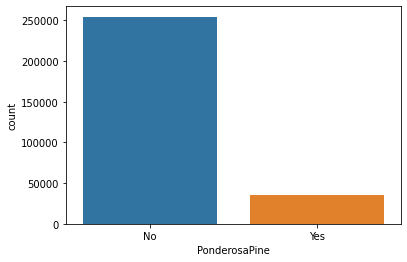

In [ ]:
y =  df['PonderosaPine']
print("타겟데이터의 비율\n",y.value_counts(normalize=True))

%matplotlib inline
sns.countplot(x=y);

In [ ]:
# train, validation, test set으로 먼저 나눠주겠습니다.

from sklearn.model_selection import train_test_split

# 타겟값이 문자형이기 때문에 수치형으로 바꿔주겠습니다.
# df['PonderosaPine'] = df['PonderosaPine'].replace({'No':0, 'Yes':1}).astype('category')

y = df['PonderosaPine']
X = df.drop('PonderosaPine', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, stratify=y_train)

print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (163311, 12)
X_val shape:  (54438, 12)
X_test shape:  (72583, 12)


In [ ]:
# XG부스트 모델
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)  # 학습데이터
X_val_encoded = encoder.transform(X_val)  # 검증데이터

boosting = XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",  # error = 1 - accuracy 지표를 사용해 평가합니다.
        n_estimators=1000,
        random_state=42,
        n_jobs=-1,
        max_depth=30,
        learning_rate=0.1,
        colsample_bytree=0.92,
        subsample=0.83,
        scale_pos_weight = 7,
)

eval_set = [(X_train_encoded, y_train), (X_val_encoded, y_val)]

boosting.fit(X_train_encoded, y_train, eval_set=eval_set, early_stopping_rounds=50)


[0]	validation_0-error:0.018137	validation_1-error:0.031485
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.018076	validation_1-error:0.030108
[2]	validation_0-error:0.012718	validation_1-error:0.023972
[3]	validation_0-error:0.012436	validation_1-error:0.02344
[4]	validation_0-error:0.010912	validation_1-error:0.021235
[5]	validation_0-error:0.010373	validation_1-error:0.020537
[6]	validation_0-error:0.009363	validation_1-error:0.019637
[7]	validation_0-error:0.008713	validation_1-error:0.019472
[8]	validation_0-error:0.008395	validation_1-error:0.0187
[9]	validation_0-error:0.007924	validation_1-error:0.018774
[10]	validation_0-error:0.007526	validation_1-error:0.01791
[11]	validation_0-error:0.007091	validation_1-error:0.017782
[12]	validation_0-error:0.006711	validation_1-error:0.017469
[13]	validation_0-error:0.006368	validation_1-error:0.017065

XGBClassifier(colsample_bytree=0.92, eval_metric='error', max_depth=30,
              n_estimators=1000, n_jobs=-1, random_state=42, scale_pos_weight=7,
              subsample=0.83)

In [ ]:
y_pred = boosting.predict(X_val_encoded)
y_pred_proba = boosting.predict_proba(X_val_encoded)[:, 1]

print("검증 accuracy", boosting.score(X_val_encoded, y_val))
print("검증 AUC", roc_auc_score(y_val, y_pred_proba))
print(classification_report(y_val, y_pred))

검증 accuracy 0.9898600242477681
검증 AUC 0.9991134648274101
              precision    recall  f1-score   support

          No       1.00      0.99      0.99     47734
         Yes       0.95      0.97      0.96      6704

    accuracy                           0.99     54438
   macro avg       0.97      0.98      0.98     54438
weighted avg       0.99      0.99      0.99     54438



In [ ]:
# ICE plot
# 예측 양상의 변화를 확인하고자 하는 데이터를 가져옵니다.
one_datapoint = X_val_encoded.iloc[[3]].copy()
Elevation_test_range = range(X_val_encoded["Elevation"].min(), X_val_encoded["Elevation"].max() + 1)

results = []

for Elevation in Elevation_test_range:
    one_datapoint["Elevation"] = Elevation  # age값을 바꿔넣어 봅니다.
    one_datapoint_pred_proba = boosting.predict_proba(one_datapoint)[
        :, 1
    ]  # 모델이 age가 바뀐 데이터로부터 확률을 예측합니다.
    results.append(one_datapoint_pred_proba.item())  # 각 확률을 리스트에 담아 둡니다.
results = np.array(results)
results -= results[0]  # 나이가 최소일 때 모델 예측 확률로부터의 변화값을 볼 것입니다.


Text(0, 0.5, '$\\Delta$ pred_proba')

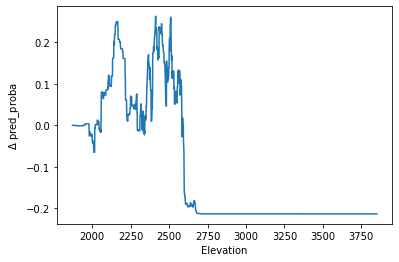

In [ ]:
import matplotlib.pyplot as plt

plt.plot(Elevation_test_range, results)
plt.xlabel("Elevation")
plt.ylabel("$\Delta$ pred_proba")

In [ ]:
def get_ice_plot_data(data, data_index, target_feature, target_feature_range):
    one_datapoint = data.iloc[[data_index]].copy()
    results = []

    for target_value in target_feature_range:
        one_datapoint[target_feature] = target_value
        one_datapoint_pred_proba = boosting.predict_proba(one_datapoint)[:, 1]
        results.append(one_datapoint_pred_proba.item())
    results = np.array(results)
    return target_feature_range, results - results[0]

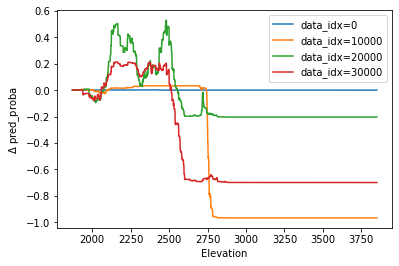

In [ ]:
target_feature = "Elevation"
target_feature_range = range(X_val_encoded["Elevation"].min(), X_val_encoded["Elevation"].max() + 1)
for data_index in [0, 10000, 20000, 30000]:
    plt.plot(
        *get_ice_plot_data(
            X_val_encoded, data_index, target_feature, target_feature_range
        ),
        label=f"data_idx={data_index}",
    )

plt.xlabel(target_feature)
plt.ylabel("$\Delta$ pred_proba")
plt.legend()

In [ ]:
X_val.iloc[[0, 10000, 20000, 30000]]

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Area,Soil_Type
34845,2669,22,17,0,0,1425,207,201,126,1321,Comanche Peak,Soil_Type20
289602,2600,116,18,612,0,726,248,220,95,1213,Comanche Peak,Soil_Type 4
172493,3149,208,19,351,127,3076,203,254,180,1198,Comanche Peak,Soil_Type33
263867,3113,188,18,895,285,4380,219,250,159,1475,Comanche Peak,Soil_Type33


(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f22990cf910>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f22990a5450>})

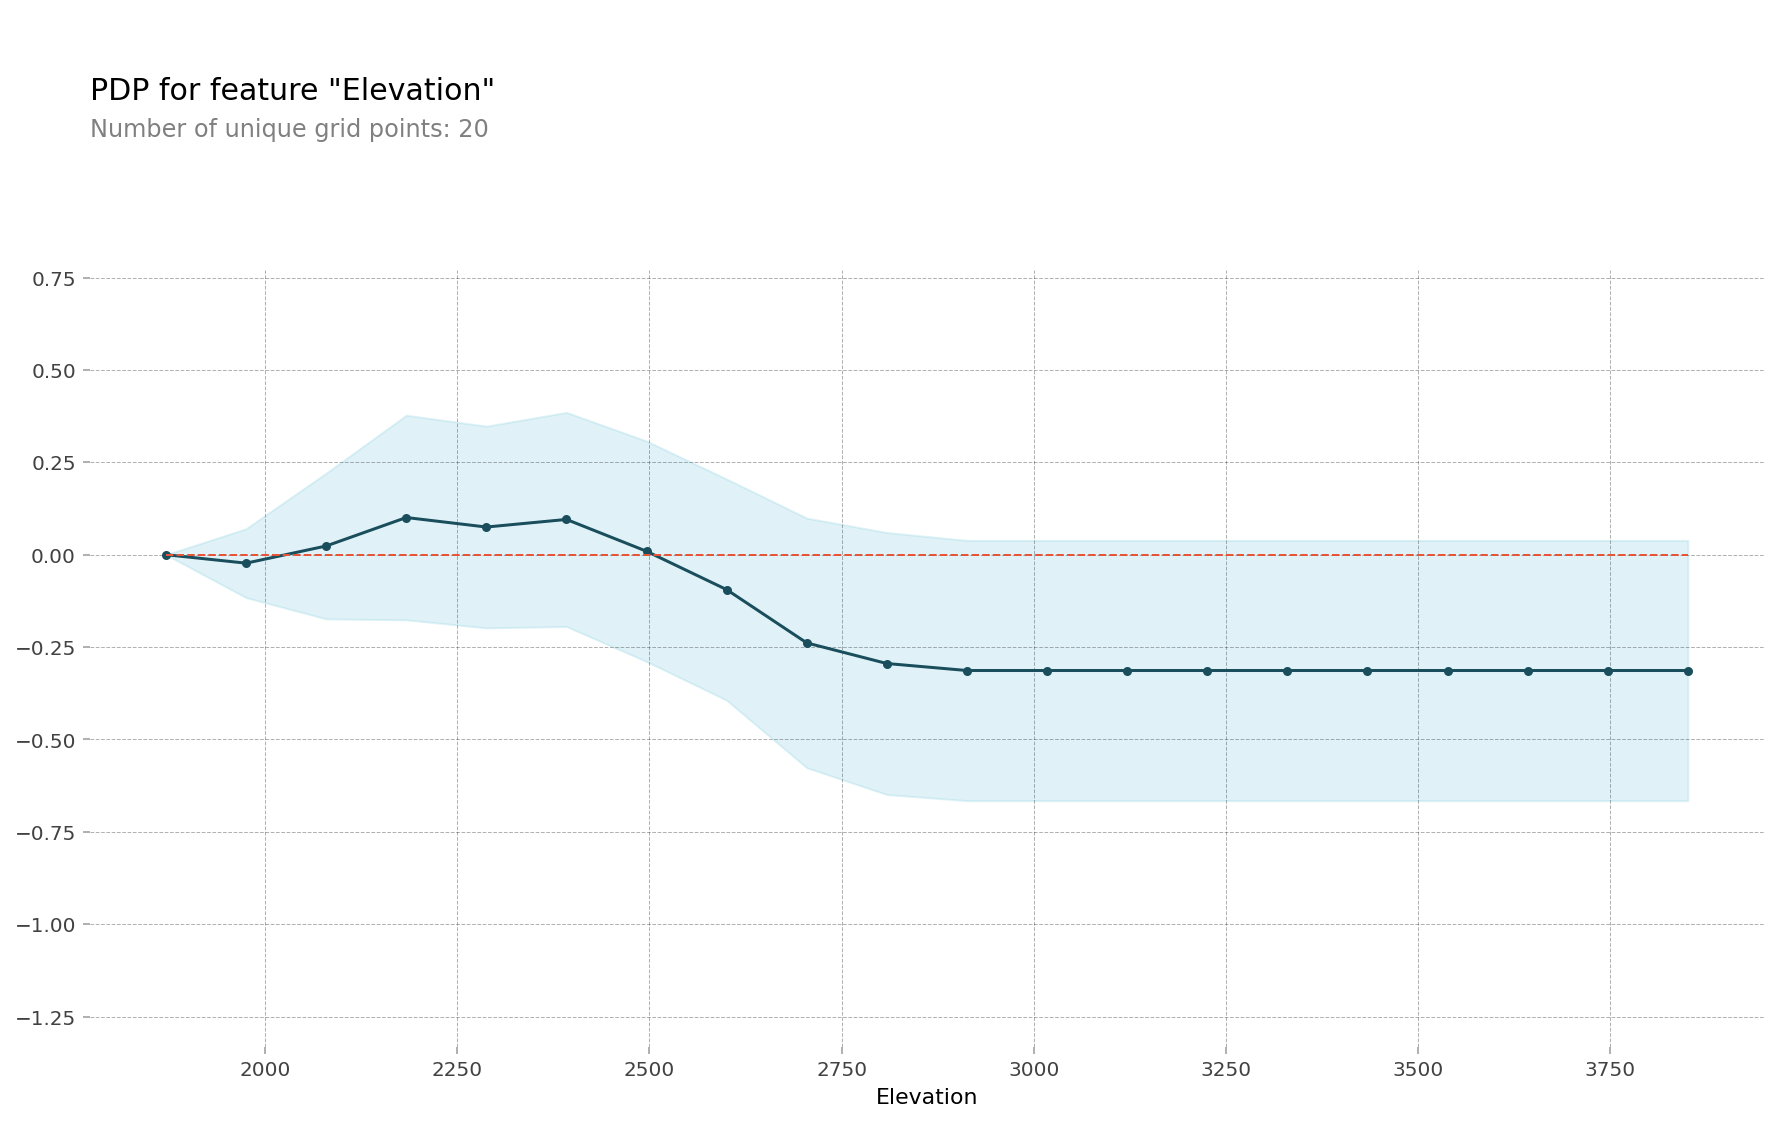

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 144

# Partial Dependence Plot (PDP)

from pdpbox.pdp import pdp_isolate, pdp_plot

target_feature = "Elevation"

isolated = pdp_isolate(
    model=boosting,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    feature=target_feature,
    grid_type="equal",  # default = 'percentile', or 'equal'
    num_grid_points=20,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)

(<Figure size 2160x1368 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f22997f4a10>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f22a3e2d590>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f22a3e4cf90>}})

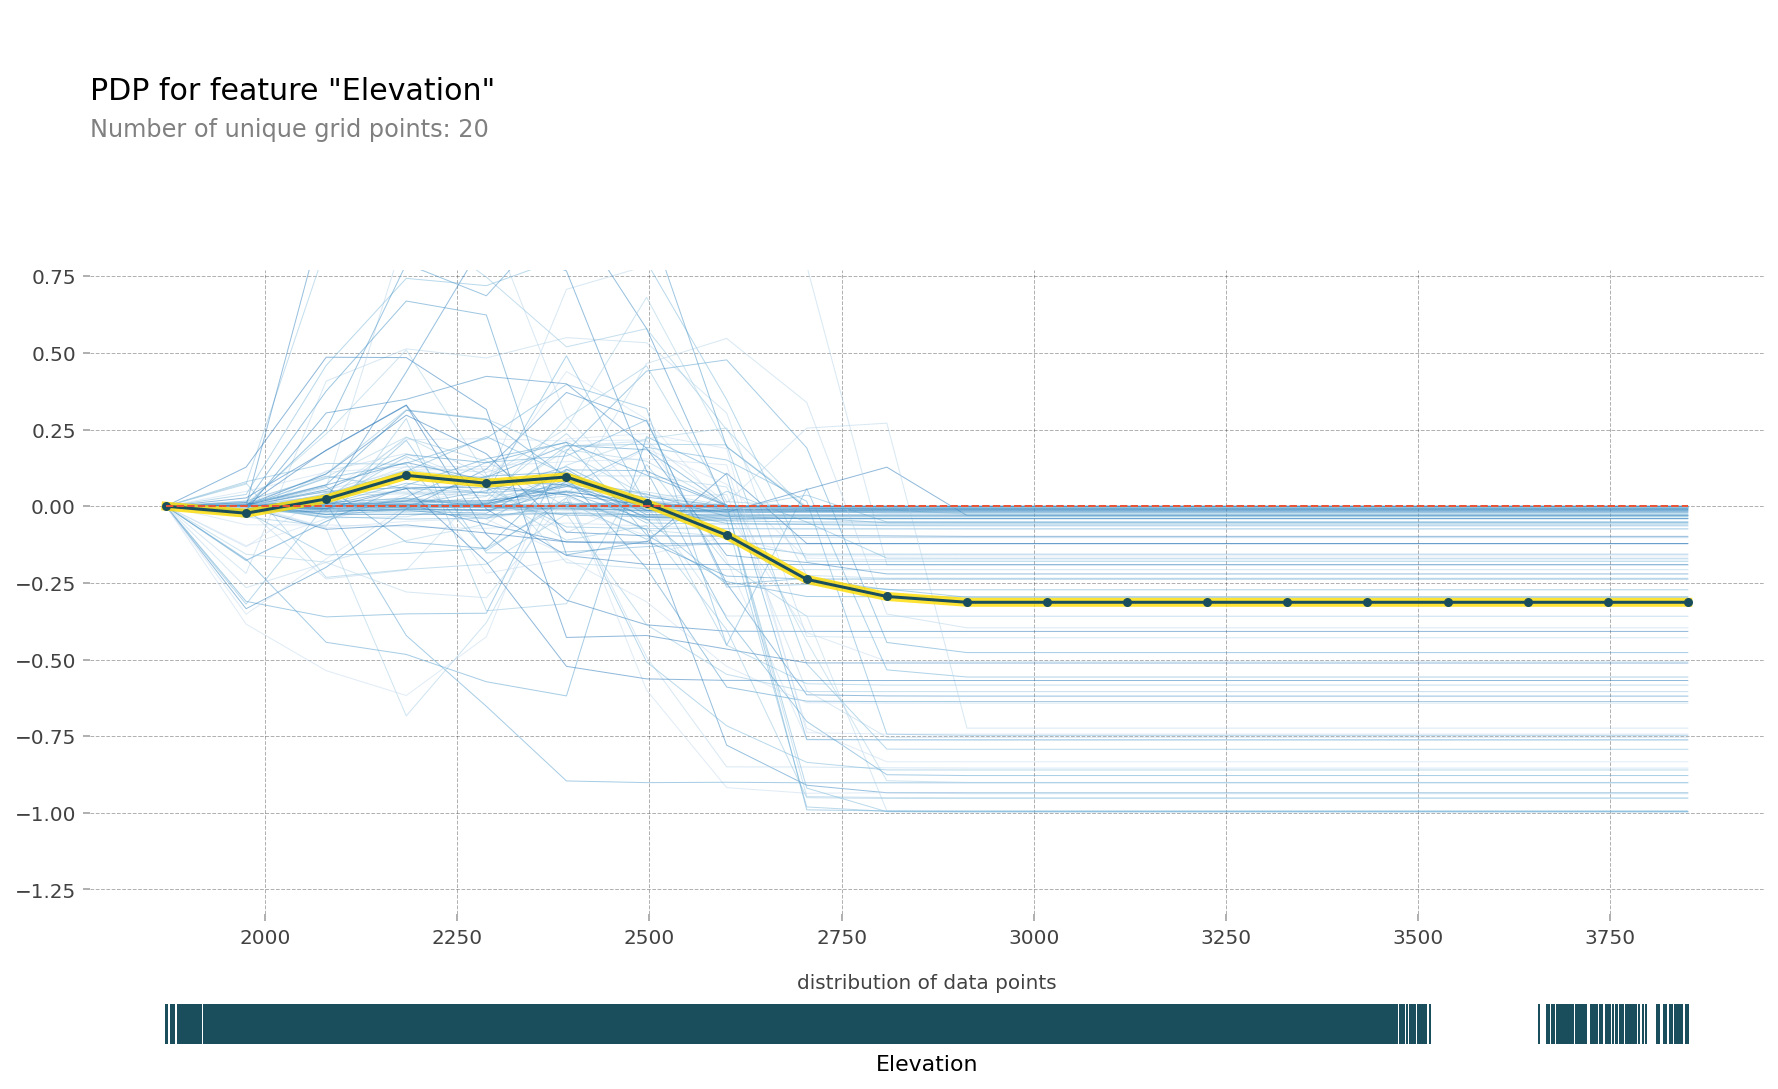

In [ ]:
pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  # ICE plots
    frac_to_plot=100,  # float type을 입력하면 전체 데이터 갯수 중 plotting할 데이터 수의 비율이 됩니다. int type을 입력하면 데이터의 수가 됩니다.
    plot_pts_dist=True,
)

(<Figure size 1080x1368 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f22997dc390>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f22975f3890>})

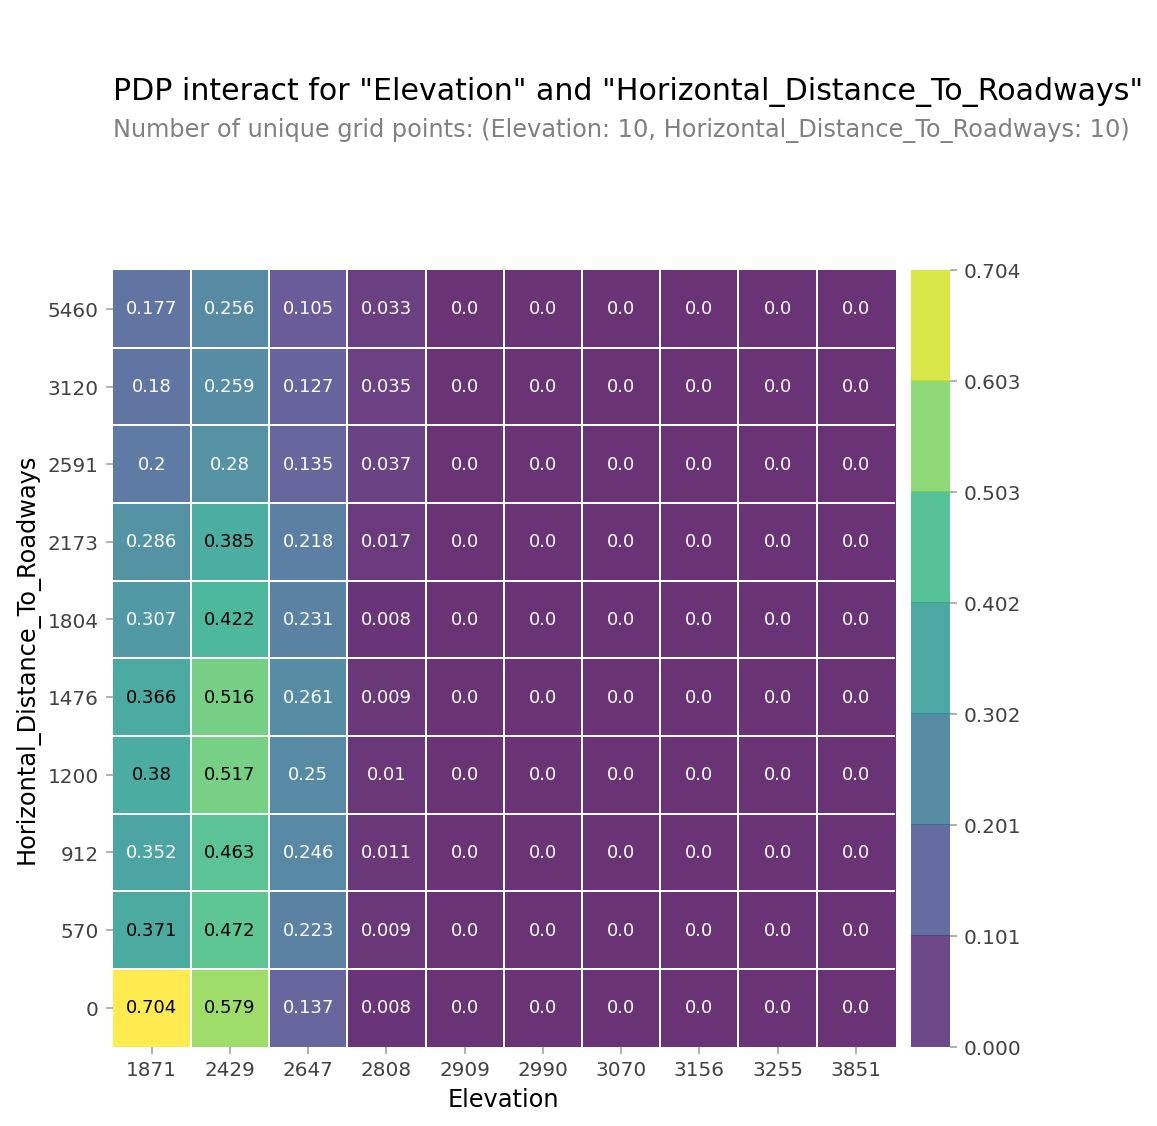

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
target_features = ["Elevation", "Horizontal_Distance_To_Roadways"]

interaction = pdp_interact(
    model=boosting,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    features=target_features,
)
pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features)

(<Figure size 1080x1368 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f22973ce750>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f229736ef90>})

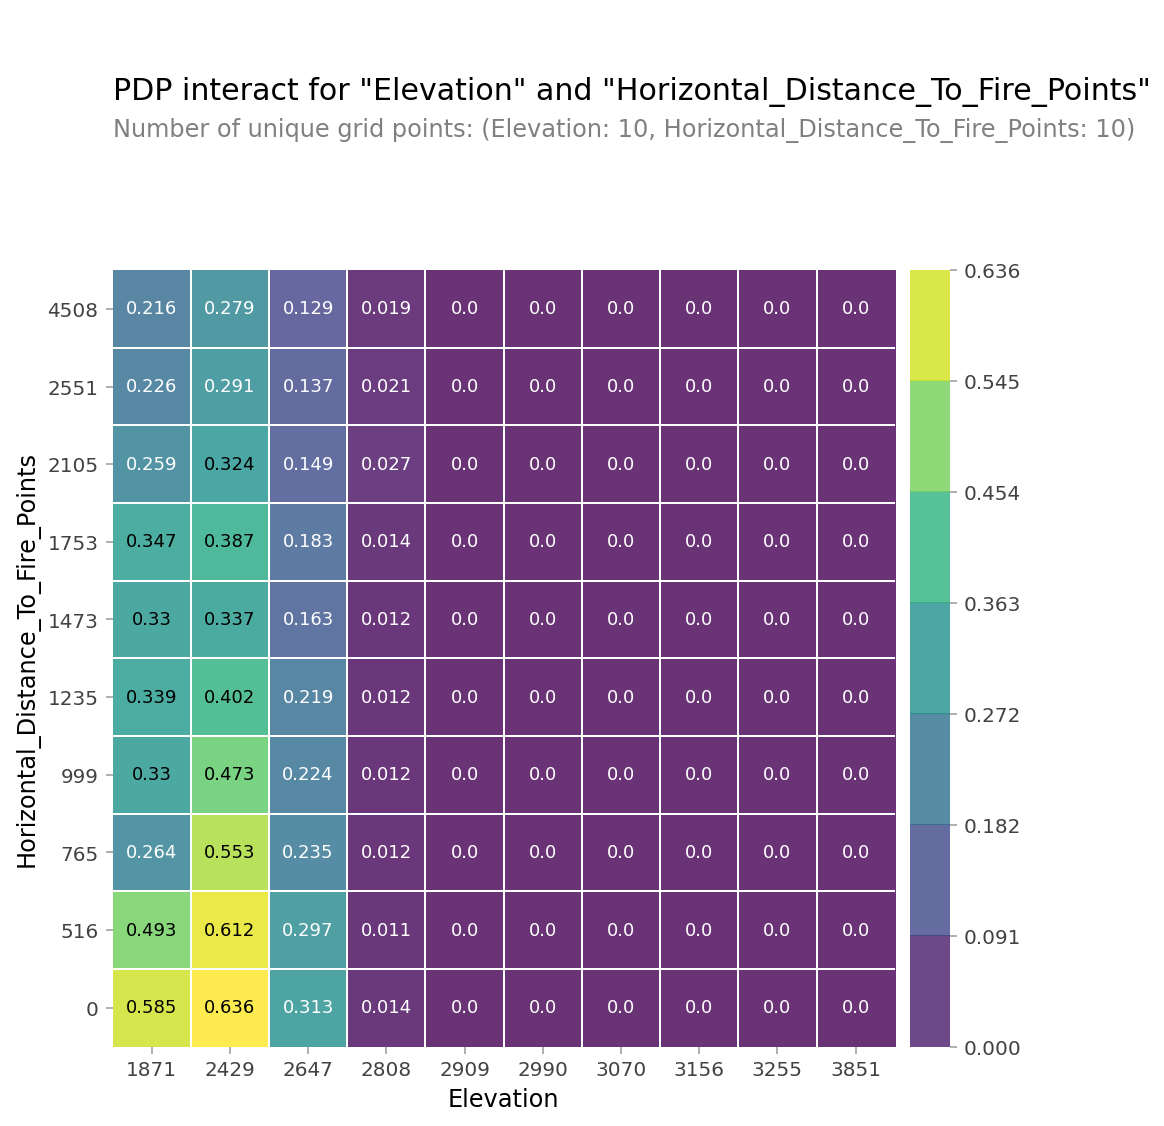

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
target_features = ["Elevation", "Horizontal_Distance_To_Fire_Points"]

interaction = pdp_interact(
    model=boosting,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    features=target_features,
)
pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features)


In [ ]:
target_features = ["Area", "Soil_Type"]
# 학습 시 사용한 encoder로부터 각 특성값들을 어떤 수치값으로 매핑했는지 확인할 수 있습니다.
mappings = encoder.mapping
print(mappings)

[{'col': 'Area', 'mapping': Comanche Peak      1
Cache la Poudre    2
NaN               -2
dtype: int64, 'data_type': CategoricalDtype(categories=['Cache la Poudre', 'Comanche Peak'], ordered=False)}, {'col': 'Soil_Type', 'mapping': Soil_Type 3     1
Soil_Type11     2
Soil_Type31     3
Soil_Type22     4
Soil_Type21     5
Soil_Type33     6
Soil_Type10     7
Soil_Type 4     8
Soil_Type17     9
Soil_Type32    10
Soil_Type40    11
Soil_Type34    12
Soil_Type 2    13
Soil_Type 6    14
Soil_Type23    15
Soil_Type20    16
Soil_Type39    17
Soil_Type13    18
Soil_Type24    19
Soil_Type38    20
Soil_Type 1    21
Soil_Type26    22
Soil_Type 5    23
Soil_Type27    24
Soil_Type35    25
Soil_Type28    26
Soil_Type14    27
Soil_Type16    28
Soil_Type19    29
Soil_Type36    30
Soil_Type37    31
Soil_Type15    32
NaN            -2
dtype: int64, 'data_type': CategoricalDtype(categories=['Soil_Type 1', 'Soil_Type 2', 'Soil_Type 3', 'Soil_Type 4',
                  'Soil_Type 5', 'Soil_Type 6', 'Soil_Typ

In [ ]:
# mappings에서 우리가 보고자 하는 타겟 특성의 mapping을 꺼내 옵시다.
mapping_data = list(filter(lambda x: x["col"] == target_feature, mappings))
print(mapping_data)

[{'col': 'Soil_Type', 'mapping': Soil_Type 3     1
Soil_Type11     2
Soil_Type31     3
Soil_Type22     4
Soil_Type21     5
Soil_Type33     6
Soil_Type10     7
Soil_Type 4     8
Soil_Type17     9
Soil_Type32    10
Soil_Type40    11
Soil_Type34    12
Soil_Type 2    13
Soil_Type 6    14
Soil_Type23    15
Soil_Type20    16
Soil_Type39    17
Soil_Type13    18
Soil_Type24    19
Soil_Type38    20
Soil_Type 1    21
Soil_Type26    22
Soil_Type 5    23
Soil_Type27    24
Soil_Type35    25
Soil_Type28    26
Soil_Type14    27
Soil_Type16    28
Soil_Type19    29
Soil_Type36    30
Soil_Type37    31
Soil_Type15    32
NaN            -2
dtype: int64, 'data_type': CategoricalDtype(categories=['Soil_Type 1', 'Soil_Type 2', 'Soil_Type 3', 'Soil_Type 4',
                  'Soil_Type 5', 'Soil_Type 6', 'Soil_Type10', 'Soil_Type11',
                  'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
                  'Soil_Type17', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21',
                  'Soil

In [ ]:
# mapping은 pandas series 형태로 저장되어 있습니다. index가 원래 값이고, value가 인코딩된 수치형 값입니다.
maps = mapping_data[0]["mapping"]
print(type(maps))
print(maps)

<class 'pandas.core.series.Series'>
Soil_Type 3     1
Soil_Type11     2
Soil_Type31     3
Soil_Type22     4
Soil_Type21     5
Soil_Type33     6
Soil_Type10     7
Soil_Type 4     8
Soil_Type17     9
Soil_Type32    10
Soil_Type40    11
Soil_Type34    12
Soil_Type 2    13
Soil_Type 6    14
Soil_Type23    15
Soil_Type20    16
Soil_Type39    17
Soil_Type13    18
Soil_Type24    19
Soil_Type38    20
Soil_Type 1    21
Soil_Type26    22
Soil_Type 5    23
Soil_Type27    24
Soil_Type35    25
Soil_Type28    26
Soil_Type14    27
Soil_Type16    28
Soil_Type19    29
Soil_Type36    30
Soil_Type37    31
Soil_Type15    32
NaN            -2
dtype: int64


In [ ]:
# 인코딩된 특성값과 원래 특성값을 리스트로 가져옵니다.
encoded_features = maps.values.tolist()
original_features = maps.index.tolist()
print(encoded_features, original_features)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, -2] ['Soil_Type 3', 'Soil_Type11', 'Soil_Type31', 'Soil_Type22', 'Soil_Type21', 'Soil_Type33', 'Soil_Type10', 'Soil_Type 4', 'Soil_Type17', 'Soil_Type32', 'Soil_Type40', 'Soil_Type34', 'Soil_Type 2', 'Soil_Type 6', 'Soil_Type23', 'Soil_Type20', 'Soil_Type39', 'Soil_Type13', 'Soil_Type24', 'Soil_Type38', 'Soil_Type 1', 'Soil_Type26', 'Soil_Type 5', 'Soil_Type27', 'Soil_Type35', 'Soil_Type28', 'Soil_Type14', 'Soil_Type16', 'Soil_Type19', 'Soil_Type36', 'Soil_Type37', 'Soil_Type15', nan]


(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f22971e3ad0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f22971d8e10>})

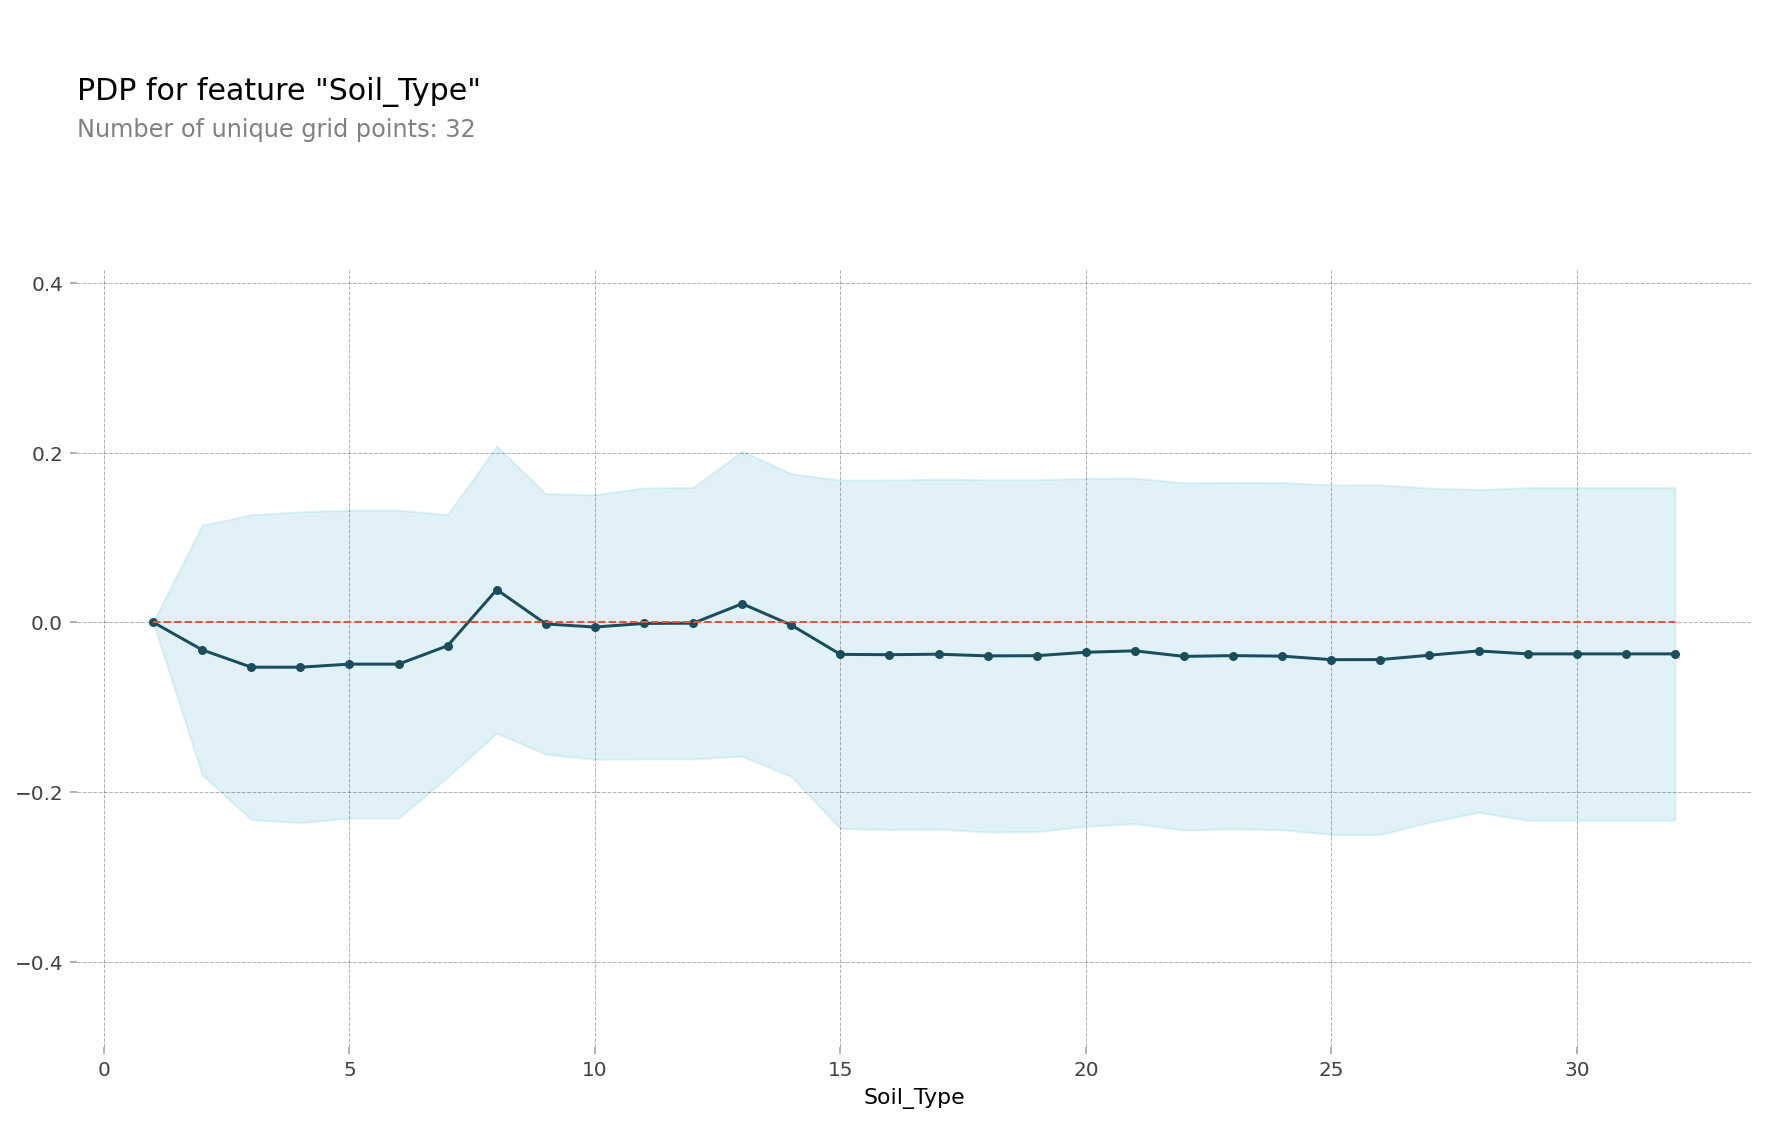

In [ ]:
# 우선 인코딩된 후의 값을 기준으로 PDP를 그려 봅시다.
pdp_dist = pdp_isolate(
    model=boosting,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    feature=target_feature,
    cust_grid_points=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,] ,  # 특성값을 찍어 볼 지점을 직접 지정할 수 있습니다.
)
pdp_plot(pdp_dist, target_feature)  # 인코딩된 marital-status 값을 확인할 수 있습니다

([<matplotlib.axis.XTick at 0x7f2297680b90>,
 [Text(0, 0, 'Soil_Type 3'),
  Text(0, 0, 'Soil_Type11'),
  Text(0, 0, 'Soil_Type31'),
  Text(0, 0, 'Soil_Type22'),
  Text(0, 0, 'Soil_Type21'),
  Text(0, 0, 'Soil_Type33'),
  Text(0, 0, 'Soil_Type10'),
  Text(0, 0, 'Soil_Type 4'),
  Text(0, 0, 'Soil_Type17'),
  Text(0, 0, 'Soil_Type32'),
  Text(0, 0, 'Soil_Type40'),
  Text(0, 0, 'Soil_Type34'),
  Text(0, 0, 'Soil_Type 2'),
  Text(0, 0, 'Soil_Type 6'),
  Text(0, 0, 'Soil_Type23'),
  Text(0, 0, 'Soil_Type20'),
  Text(0, 0, 'Soil_Type39'),
  Text(0, 0, 'Soil_Type13'),
  Text(0, 0, 'Soil_Type24'),
  Text(0, 0, 'Soil_Type38'),
  Text(0, 0, 'Soil_Type 1'),
  Text(0, 0, 'Soil_Type26'),
  Text(0, 0, 'Soil_Type 5'),
  Text(0, 0, 'Soil_Type27'),
  Text(0, 0, 'Soil_Type35'),
  Text(0, 0, 'Soil_Type28'),
  Text(0, 0, 'Soil_Type14'),
  Text(0, 0, 'Soil_Type16'),
  Text(0, 0, 'Soil_Type19'),
  Text(0, 0, 'Soil_Type36'),
  Text(0, 0, 'Soil_Type37'),
  Text(0, 0, 'Soil_Type15'),
  Text(0, 0, 'nan')])

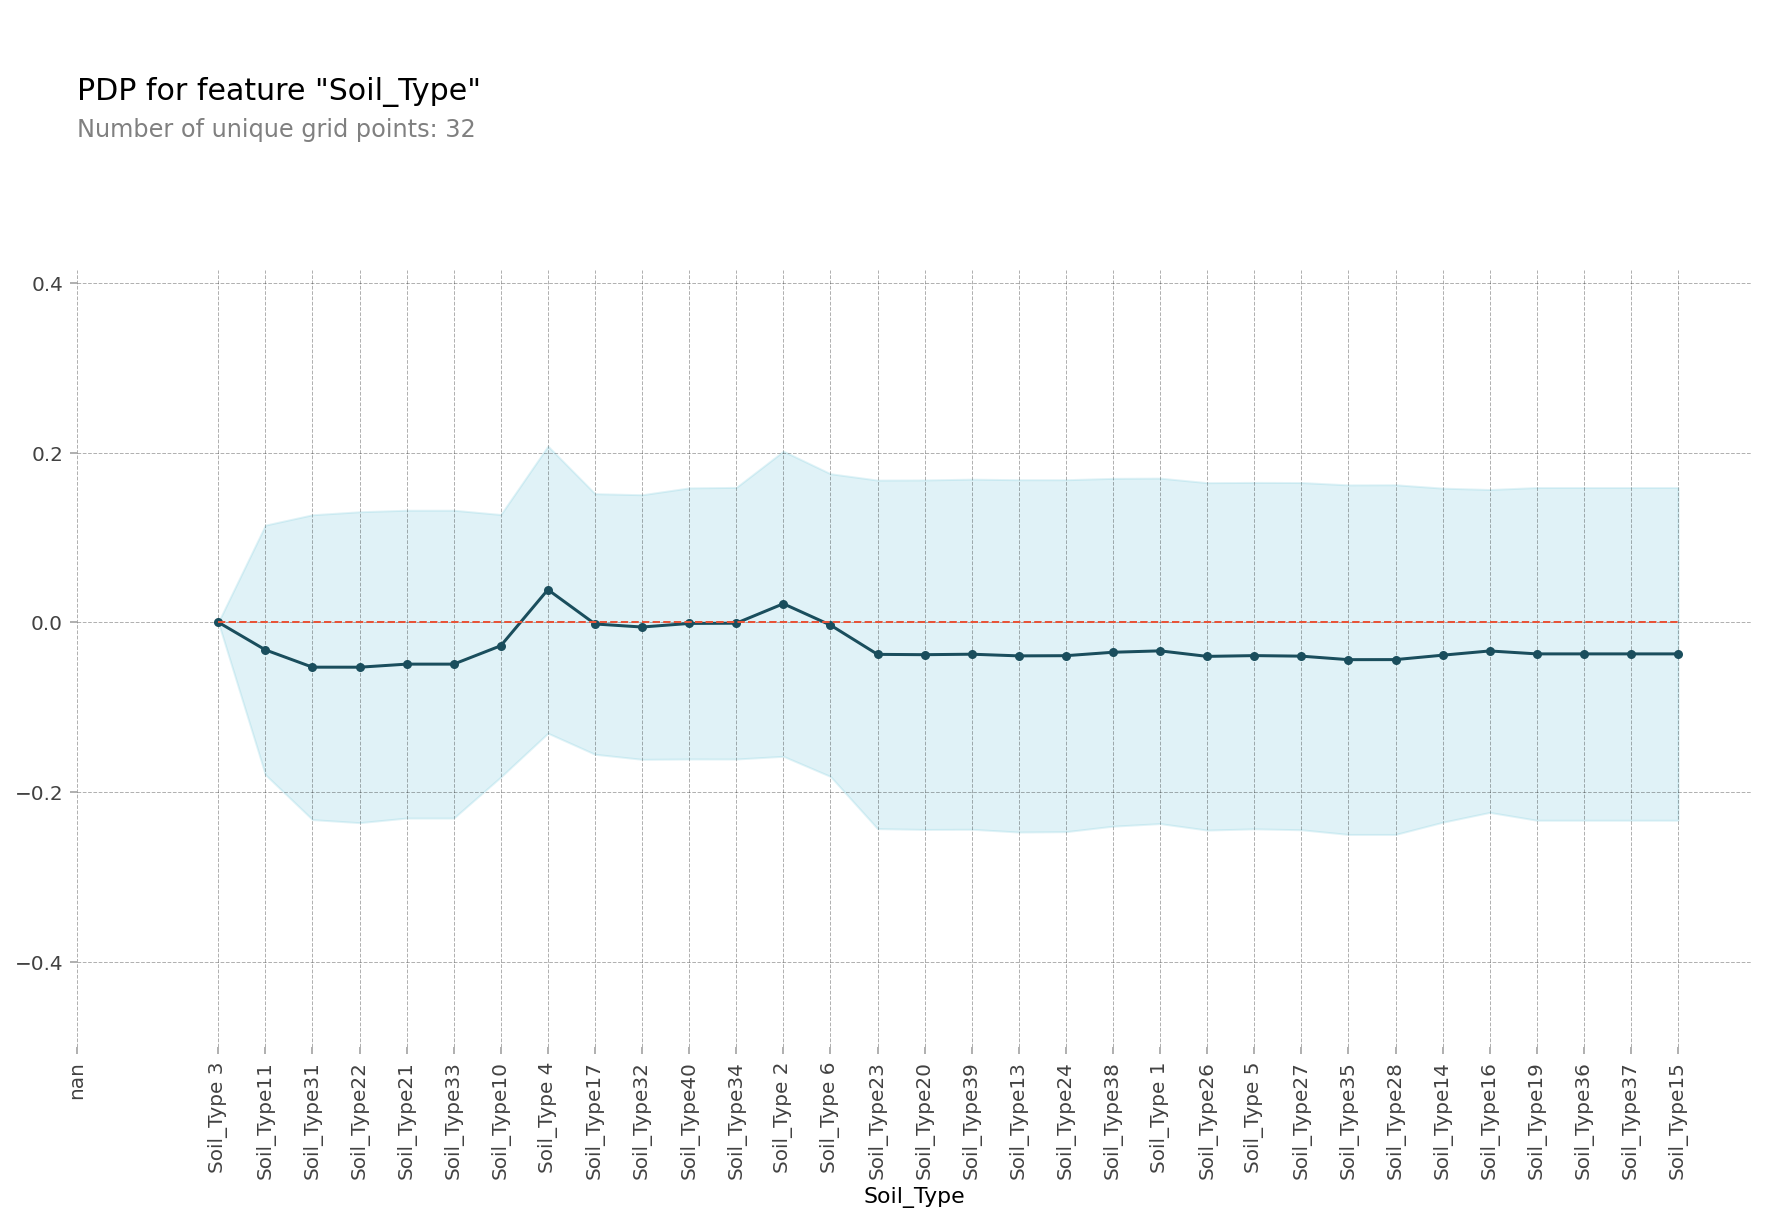

In [ ]:
pdp_plot(pdp_dist, target_feature)

# plot의 x축에 표시될 값을 encoded features에서 original features로 매핑해 줍니다.
plt.xticks(encoded_features, original_features, rotation=90)

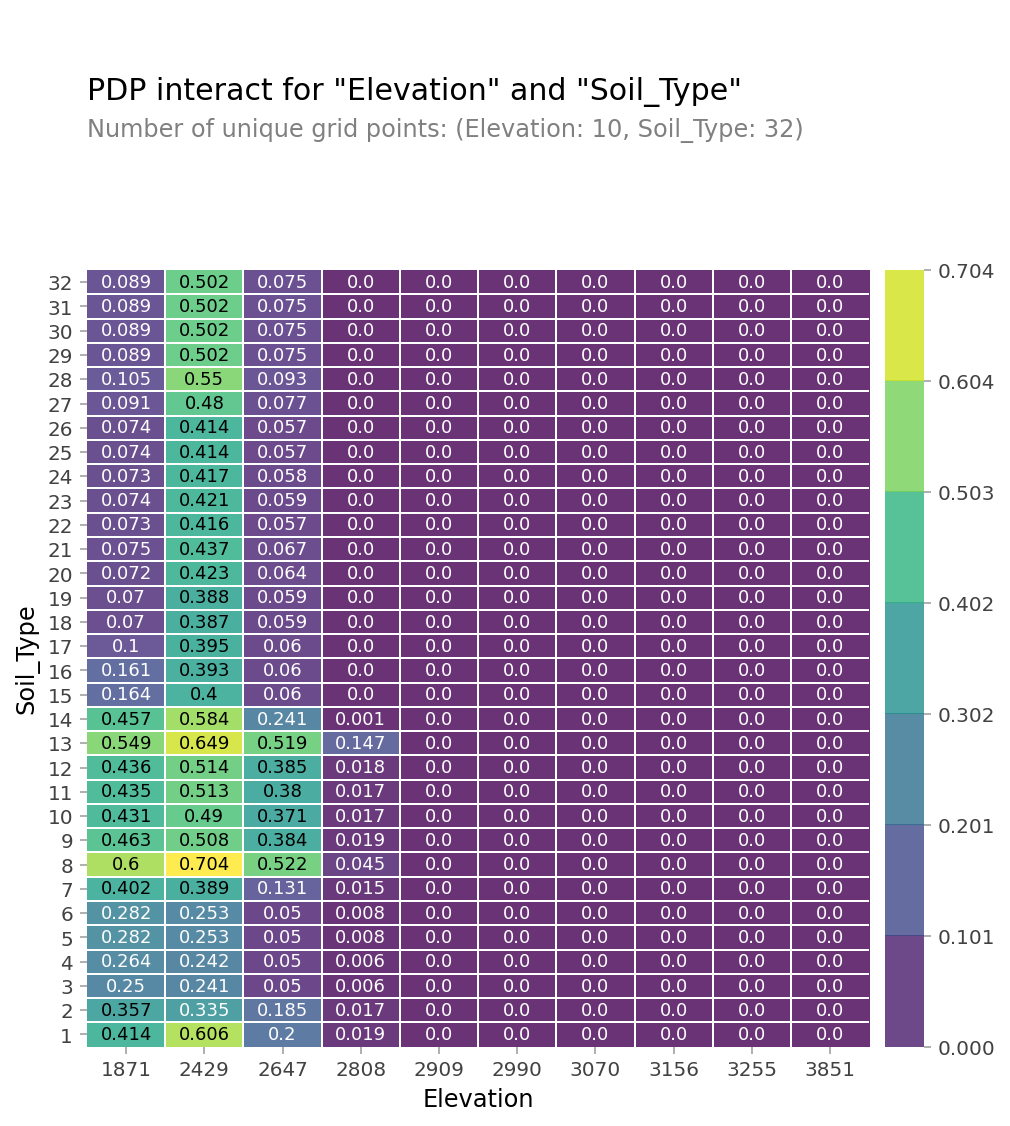

In [ ]:
target_features = ["Elevation", "Soil_Type",]

interaction = pdp_interact(
    model=boosting,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    features=target_features,
    cust_grid_points=[
        None,
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,], 
         # 첫 번째 특성인 marital-status에 대해서는 grid point를 지정해 주고,
    ],
)

axes = pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features)
plot_params={'yticks':[encoded_features, original_features]}


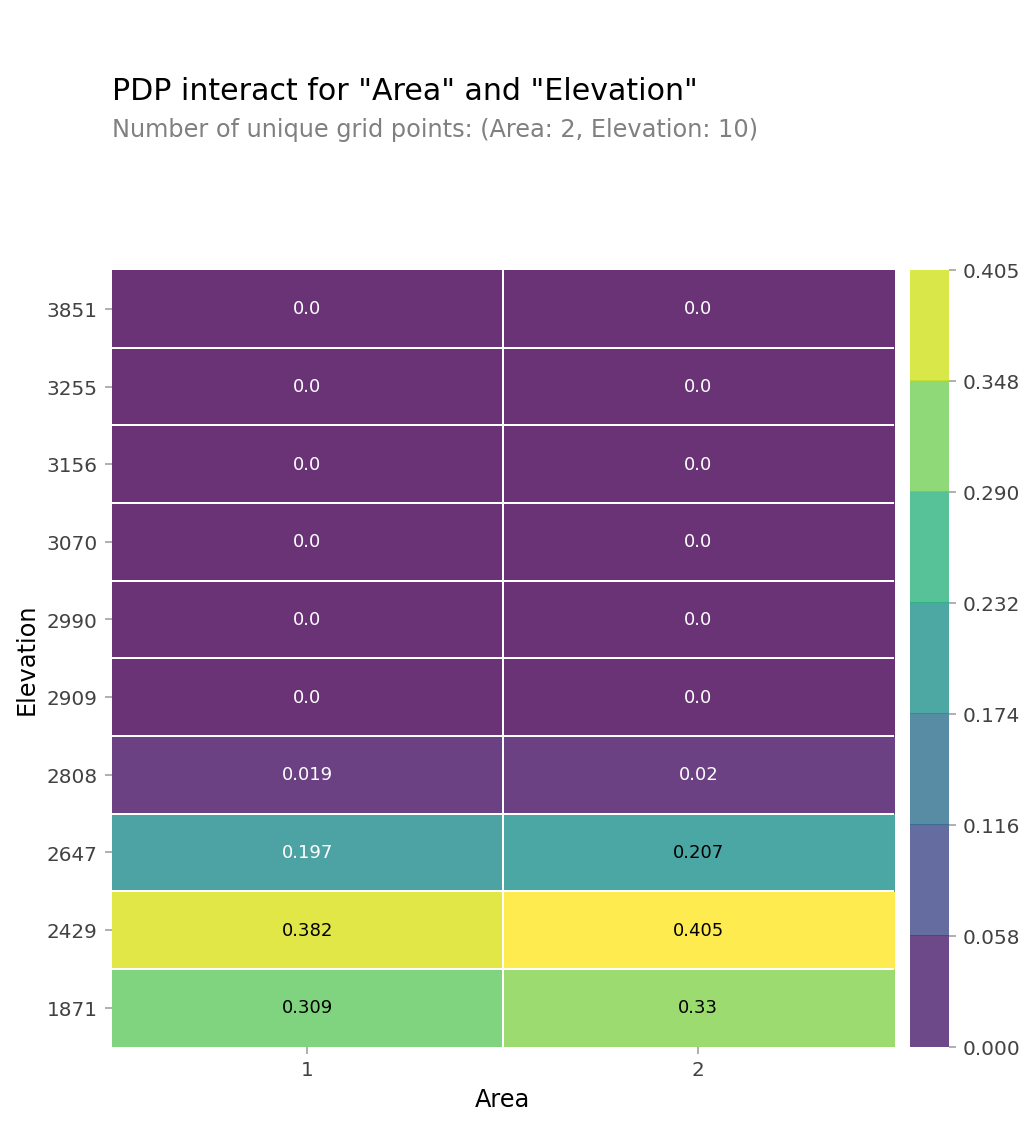

In [ ]:
target_features = ["Area", "Elevation"]

interaction = pdp_interact(
    model=boosting,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    features=target_features,
    cust_grid_points=[
        [1, 2], 
        None,
    ],
)

axes = pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features)
plot_params={'xticks':[encoded_features, original_features]}

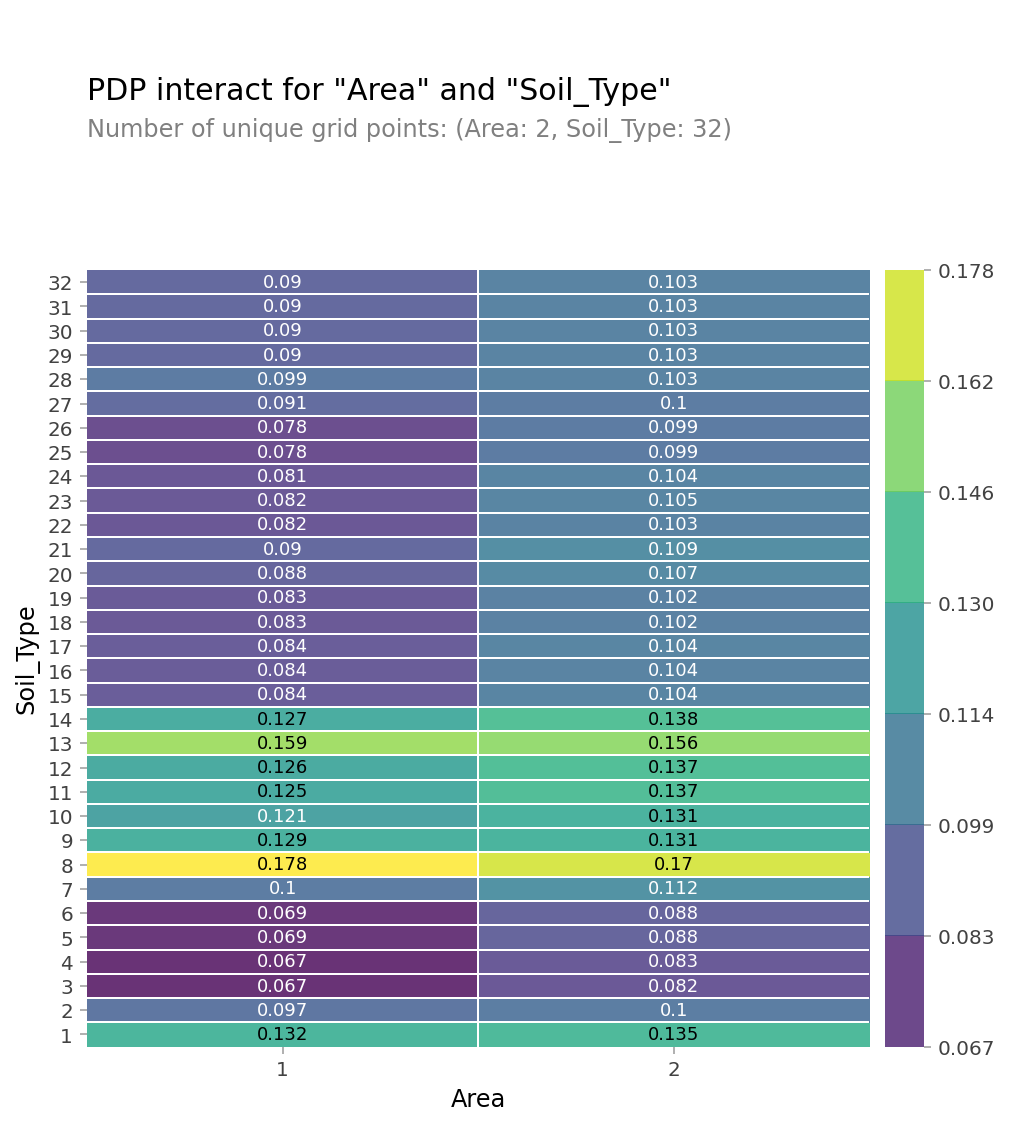

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
target_features = ["Area", "Soil_Type"]

interaction = pdp_interact(
    model=boosting,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    features=target_features,
    cust_grid_points=[
        [1, 2],
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,],
    ],
)

axes = pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features)
plot_params={'yticks':[encoded_features, original_features]}

Text(0.5, 1.0, "PDP of ['Area', 'Soil_Type'], decoded categorical")

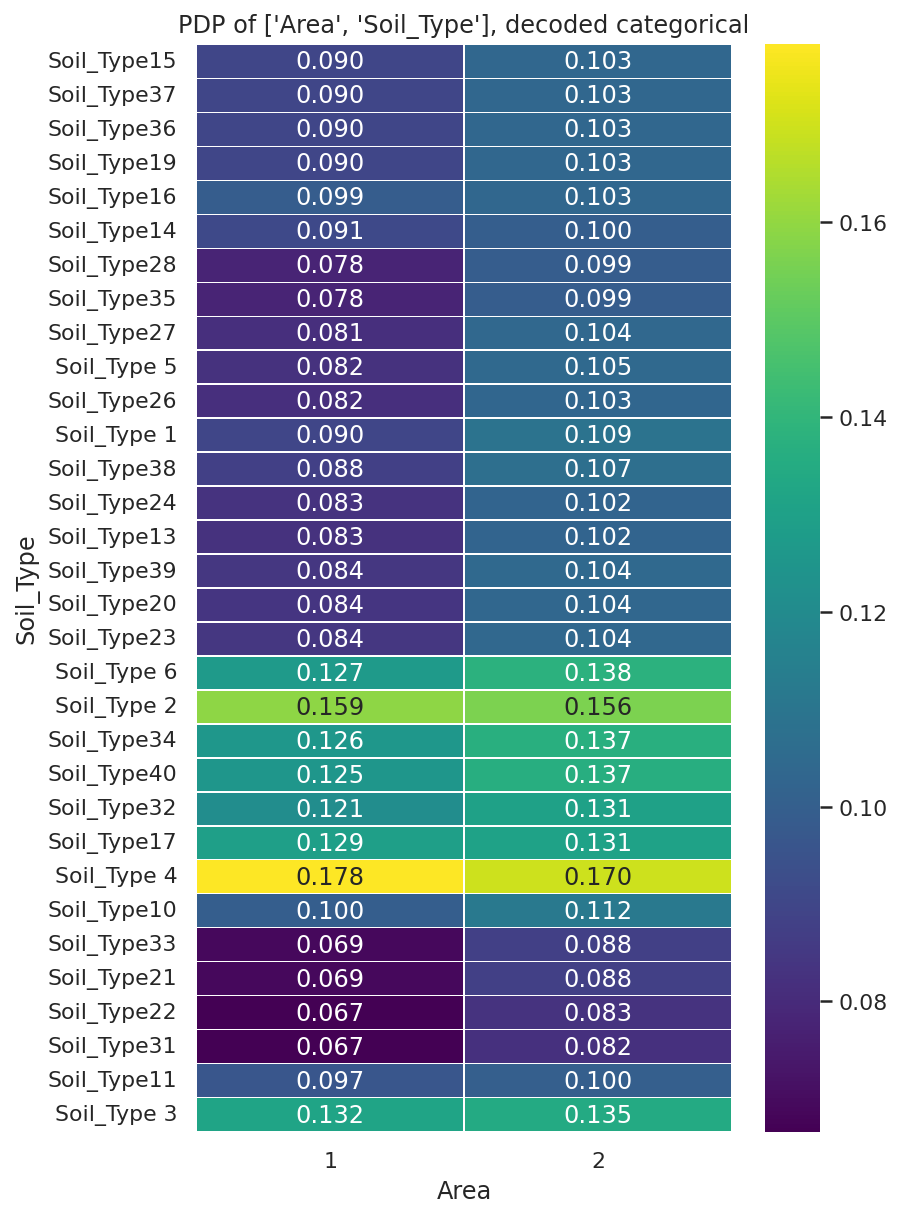

In [ ]:
import seaborn as sns
target_features = ["Area", "Soil_Type"]

pdp_pivoted_data = interaction.pdp.pivot_table(
    values="preds", columns=target_features[0], index=target_features[1]
)[::-1]

# pdp_pivoted_data DataFrame의 columndms categorical인 marital-status입니다. column을 rename합시다.
pdp_pivoted_data.rename(
    index=dict(zip(encoded_features, original_features),), inplace=True
)
sns.set(rc = {'figure.figsize':(6,10)})
sns.heatmap(data=pdp_pivoted_data, annot=True, fmt=".3f", cmap="viridis",linewidths=0.2)
plt.title(f"PDP of {target_features}, decoded categorical")